In [1]:
import math, random
import torch
import torchaudio
import shutil
import os
import time
from torchaudio import transforms as T
from IPython.display import Audio
from pathlib import Path
import matplotlib.pyplot as plt
from os import walk
import librosa
import numpy as np
import librosa.display
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader

In [2]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

In [35]:
def turn_specgram(dir):
  audiodir = Path(dir)
  sig, sr = torchaudio.load(audiodir)
  top_db = 80
  spec = T.MelSpectrogram(sr, n_fft=1024
                                 , hop_length=None, n_mels=64)(sig)
  spec = T.AmplitudeToDB(top_db=top_db)(spec)
  #plot_specgram(sig, sr)
  #librosa.display.specshow(librosa.power_to_db(spec[0], ref=np.max))
  #print(spec, spec.shape)
  return spec

f = []
for (tmp,tmp2,filenames) in walk(Path('Music')):
    f = filenames
for x in f:
  turn_specgram("Music/train/"+x)


In [37]:
class AudioSet:
  def __init__(self, path_dir, file_types=['wav'], transform=None):
    self.path = Path(path_dir)
    self.audio_fns = sorted(item for y in [list(self.path.rglob(f'*.wav'))] for item in y) 
    self.classes = sorted(list(set([x.parent.name for x in self.audio_fns])))
    self.cls2idx = {k: i for i, k in enumerate(self.classes)}

  def __len__(self):
    return len(self.audio_fns)
  
  def __getitem__(self, idx):
    aud_path = self.audio_fns[idx]
    aud = turn_specgram(aud_path)
    aud = torch.cat((aud[0], aud[1], aud[0]),0)
    aud=aud.resize(3,64,469)
    cls = aud_path.parent.name
    return aud, self.cls2idx[cls]

trainset = AudioSet('Music/train')
print(trainset[0], trainset[0][0].shape)
print(trainset[6], trainset[6][0].shape)

(tensor([[[-40.3458, -40.3458, -40.3458,  ...,  30.7296,  30.8192,  31.9201],
         [-40.3458, -40.3458, -40.3458,  ...,  33.2930,  33.8525,  34.8503],
         [-40.3458, -40.3458, -40.3458,  ...,  29.9754,  30.5858,  31.4131],
         ...,
         [-40.3458, -40.3458, -40.3458,  ..., -40.3458, -40.3458, -40.3458],
         [-40.3458, -40.3458, -40.3458,  ..., -40.3458, -40.3458, -40.3458],
         [-40.3458, -40.3458, -40.3458,  ..., -40.3458, -40.3458, -40.3458]],

        [[-40.3458, -40.3458, -40.3458,  ...,  28.3297,  29.2483,  29.9149],
         [-40.3458, -40.3458, -40.3458,  ...,  31.2271,  31.7782,  32.2244],
         [-40.3458, -40.3458, -40.3458,  ...,  29.0158,  28.7010,  27.7938],
         ...,
         [-40.3458, -40.3458, -40.3458,  ..., -40.3458, -40.3458, -40.3458],
         [-40.3458, -40.3458, -40.3458,  ..., -40.3458, -40.3458, -40.3458],
         [-40.3458, -40.3458, -40.3458,  ..., -40.3458, -40.3458, -40.3458]],

        [[-40.3458, -40.3458, -40.3458,  ..

In [38]:
class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='resnet'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.model.to(self.device)
    self.criterion = nn.NLLLoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    self.best_loss = np.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval()
    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode():
      for batch in self.valid_loader:
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        outputs = self.model(images)
        probs = torch.softmax(outputs, dim=-1)
        log_probs = torch.log(probs)
        loss = self.criterion(log_probs, labels)
        predicted_classes = torch.argmax(outputs, dim=-1)
        num_acc_pred = (predicted_classes == labels.to(self.device)).sum()
        num_total_correct_pred += num_acc_pred.item()
        current_loss += loss.item() * len(labels)
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset)
    return mean_loss, mean_acc

  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(images) 
        probs = torch.softmax(outputs, dim=-1)
        log_probs = torch.log(probs)
        loss = self.criterion(log_probs, labels) 

        acc = (torch.argmax(outputs, dim=-1) == labels.to(self.device)).sum() / len(labels)
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
      valid_loss, valid_acc = self.validation()

      if valid_acc > self.best_acc:
        self.best_acc = valid_acc
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")


class Interpreter:
  def __init__(self, model, test_loader):
    self.model = model
    self.loader = test_loader
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.criterion = nn.NLLLoss(reduction='none')
    self.test_losses, self.test_preds = self.infer_loader()

  def infer_loader(self):
    self.model.to(self.device)
    self.model.eval()
    losses = torch.zeros(len(self.loader.dataset))
    predicted_classes = torch.zeros(len(self.loader.dataset))
    current_idx = 0
    with torch.inference_mode():
      for batch in self.loader:
        imgs, labels = batch
        imgs, labels = imgs.to(self.device), labels.to(self.device)
        outputs = self.model(imgs)
        log_probs = torch.log(torch.softmax(outputs, dim=-1))
        loss = self.criterion(log_probs, labels)
        losses[current_idx:current_idx+len(labels)] = loss.cpu()
        predicted_classes[current_idx:current_idx+len(labels)] = torch.argmax(outputs, dim=-1).cpu()
        current_idx += len(labels)
    predicted_classes = predicted_classes.long().tolist()
    return losses, predicted_classes


  def plot_top_losses(self, topk=10):
    top_losses, top_idx = torch.topk(self.test_losses, k=topk)
    fig, axes = plt.subplots(topk, 1, figsize=(5, 5*topk))
    class_names = self.loader.dataset.classes
    for i in range(topk):
      img, label = self.loader.dataset[top_idx[i]]
      axes[i].set_title(f"True: {class_names[label]} /  Pred: {class_names[self.test_preds[top_idx[i]]]} / Loss: {top_losses[i]:.4f}, ")
      axes[i].axis('off')

  def plot_confusion_matrix(self):
    class_names = self.loader.dataset.classes
    confusion_matrix = torch.zeros(len(class_names), len(class_names))
    for i in range(len(self.loader.dataset)):
      confusion_matrix[self.loader.dataset[i][1], self.test_preds[i]] += 1
    confusion_matrix = confusion_matrix.numpy()
    plt.figure(figsize = (10,7))
    plt.imshow(confusion_matrix)
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    plt.yticks(range(len(class_names)), class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for (x, y), value in np.ndenumerate(confusion_matrix):
      plt.text(y, x, f"{int(value)}", va="center", ha="center")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving best model at epoch 0, acc: 0.5333333333333333


  0%|          | 0/3 [00:00<?, ?it/s]

Saving best model at epoch 1, acc: 0.7333333333333333


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving best model at epoch 3, acc: 1.0


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

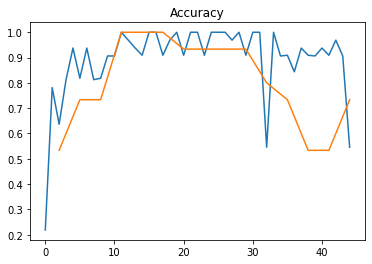

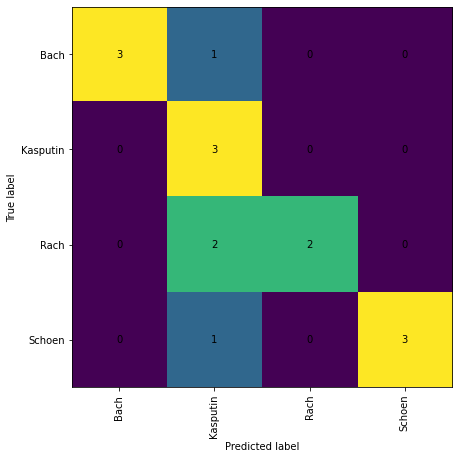

In [69]:
trainset = AudioSet('Music/train')
testset = AudioSet('Music/test')
test_loader = DataLoader(testset, batch_size=32, shuffle=False)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)

model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(trainset.classes))
trainer = Trainer(model, train_loader, test_loader, 'with_pretraining')
trainer.train_by_number_of_epochs(num_epochs=15)

interpreter = Interpreter(model, test_loader)
interpreter.plot_confusion_matrix()